# Databricks Collaboration & Adoption Monitor

## Overview

This notebook provides a **comprehensive analysis of platform adoption and user collaboration** by tracking user activity, feature usage, AI/agent adoption, and collaboration patterns. The output includes detailed reports on active users, feature adoption rates, AI assistant usage, inactive accounts, and training needs.

**✨ Enterprise-grade adoption monitoring with user activity tracking, AI/agent usage analysis, feature adoption metrics, and collaboration insights.**

---

## Features

### User Activity Tracking
* **Active Users**: Daily (DAU), Weekly (WAU), Monthly (MAU) active users
* **Login Patterns**: Last login times, login frequency
* **Inactive Users**: Users with no activity in 30/60/90 days
* **User Segmentation**: Power users, regular users, occasional users, inactive
* **Activity Trends**: Week-over-week, month-over-month growth

### Feature Usage Analysis
* **Notebooks**: Execution counts, users running notebooks
* **SQL Queries**: Query execution, SQL warehouse usage
* **Dashboards**: Dashboard views, dashboard creators
* **Jobs/Workflows**: Job creators, job execution patterns
* **Repos (Git)**: Git integration usage, active repos
* **MLflow**: Experiment tracking, model registry usage
* **Delta Live Tables**: Pipeline usage and creators

### AI & Agent Adoption
* **AI Assistant Usage**: Users leveraging Databricks Assistant
* **Agent Interactions**: Frequency of agent usage per user
* **Agent Features**: Code generation, query assistance, debugging
* **Adoption Rate**: % of users using AI features
* **Power AI Users**: Top users by agent interaction count
* **AI Feature Breakdown**: Which AI features are most used

### Collaboration Metrics
* **Shared Notebooks**: Notebooks in /Shared folders
* **Workspace Sharing**: Users collaborating on same assets
* **Group Membership**: Users in multiple groups
* **Cross-Team Collaboration**: Activity across departments

### Adoption Insights
* **Feature Adoption Rates**: % of users using each feature
* **Adoption Trends**: Feature usage over time
* **Training Needs**: Users with low activity
* **Onboarding Success**: New user activity patterns
* **Department Analysis**: Usage by team/department

### Recommendations
* **Inactive User Cleanup**: Accounts to deactivate
* **Training Opportunities**: Users who could benefit from training
* **Feature Promotion**: Underutilized features to promote
* **AI Adoption**: Users who should try AI assistant

---

## Version Control

| Version | Date | Author | Changes |
|---------|------|--------|---------|  
| 1.0.0 | 2026-02-16 | Assistant | Comprehensive collaboration and adoption monitoring system with complete user activity tracking. Features include: user inventory with activity status, login pattern analysis, active user metrics (DAU/WAU/MAU), feature usage tracking across notebooks, SQL queries, dashboards, jobs, repos, MLflow, and DLT pipelines, AI/agent usage analysis (Databricks Assistant adoption, interaction frequency, feature breakdown), inactive user identification (30/60/90 day thresholds), user segmentation (power users, regular, occasional, inactive), collaboration metrics (shared notebooks, cross-team activity, group membership), adoption rate calculations per feature, adoption trend analysis, training needs identification, recommendations for inactive user cleanup and feature promotion, multiple export formats (Delta table with historical tracking, Excel multi-sheet workbook), interactive visualizations (adoption trends, feature usage heatmap, AI adoption charts), system.access.audit log queries for activity data, job mode support with automatic configuration, serverless compute optimization, parallel processing, retry logic, progress tracking, and comprehensive error handling. |

---

## Configuration

### Analysis Period:
* `LOOKBACK_DAYS = 30` - Days of activity to analyze (default: 30)
* `INACTIVE_THRESHOLD_DAYS = 90` - Days to consider user inactive
* `POWER_USER_THRESHOLD = 50` - Activity count to classify as power user

### Activity Thresholds:
* `MIN_ACTIVITY_FOR_ACTIVE = 1` - Minimum actions to count as active
* `DAU_DAYS = 1` - Daily active users lookback
* `WAU_DAYS = 7` - Weekly active users lookback
* `MAU_DAYS = 30` - Monthly active users lookback

### Export Settings:
* `EXPORT_PATH = '/dbfs/tmp/adoption_export'` - Export directory
* `ENABLE_EXCEL_EXPORT = True` - Excel workbook generation
* `ENABLE_DELTA_EXPORT = True` - Delta table for historical tracking
* `ENABLE_VISUALIZATIONS = True` - Generate charts (interactive mode)
* `DELTA_TABLE_NAME = 'main.default.adoption_history'` - Delta table name

### Performance Settings:
* `MAX_USERS = 999` - Maximum users to analyze (999 = all)
* `MAX_WORKERS = 10` - Parallel threads for API calls
* `MAX_RETRIES = 3` - Retries for failed operations

---

## Usage

### Interactive Mode
1. Run all cells to analyze adoption metrics
2. Review user activity and feature usage
3. Identify AI/agent adoption patterns
4. View visualizations and trends
5. Download Excel report from export path

### Job Mode
1. Schedule as a Databricks job (weekly recommended)
2. Automatically runs comprehensive analysis
3. Exports to Delta table for trend tracking
4. Returns JSON summary for orchestration

---

## Data Sources

| Data Source | Purpose |
|-------------|----------|
| `system.access.audit` | User activity logs (notebook runs, queries, dashboard views, agent usage) |
| Databricks SDK - Users API | User inventory, login times, active status |
| Databricks SDK - Groups API | Group membership, collaboration patterns |
| Workspace API | Shared notebooks, collaboration metrics |

---

## Key Features

✓ **User Activity Tracking**: DAU/WAU/MAU metrics  
✓ **AI/Agent Usage**: Databricks Assistant adoption tracking  
✓ **Feature Adoption**: Usage rates across all platform features  
✓ **Inactive User Detection**: 30/60/90 day inactivity thresholds  
✓ **Power User Identification**: Top users by activity  
✓ **Collaboration Metrics**: Shared workspace analysis  
✓ **Training Needs**: Identify users needing support  
✓ **Adoption Trends**: Historical trend analysis  
✓ **System Table Queries**: Leverages system.access.audit  
✓ **Multiple Export Formats**: Excel and Delta table  
✓ **Interactive Visualizations**: Charts and heatmaps  
✓ **Job Mode Support**: Automated scheduled execution  
✓ **Serverless Optimized**: Compute-aware optimizations  
✓ **Comprehensive Error Handling**: Graceful degradation  
✓ **Historical Tracking**: Delta table with append mode

In [0]:
%pip install openpyxl --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard library
import time
import os
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Third-party
import pandas as pd
import pytz

# Databricks SDK
from databricks.sdk import WorkspaceClient
from databricks.sdk.errors import NotFound, PermissionDenied

# PySpark
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, TimestampType, DoubleType

# ============================================================================
# JOB MODE DETECTION (MUST BE FIRST)
# ============================================================================

try:
    dbutils.notebook.entry_point.getDbutils().notebook().getContext().currentRunId().isDefined()
    is_job_mode = True
except:
    is_job_mode = False

# ============================================================================
# SERVERLESS DETECTION
# ============================================================================

try:
    test_df = spark.range(1)
    test_df.cache()
    test_df.count()
    test_df.unpersist()
    is_serverless = False
except Exception as e:
    if 'PERSIST' in str(e).upper() or 'CACHE' in str(e).upper():
        is_serverless = True
    else:
        is_serverless = False

# ============================================================================
# TIMEZONE CONFIGURATION
# ============================================================================

TIMEZONE = 'America/New_York'
eastern = pytz.timezone(TIMEZONE)

# ============================================================================
# LOGGING FUNCTION
# ============================================================================

def log(message):
    """Print messages (always in interactive, selectively in job mode)"""
    print(message)

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Analysis period
LOOKBACK_DAYS = 30  # Days of activity to analyze

# Activity thresholds
INACTIVE_THRESHOLD_DAYS = 90  # Days to consider user inactive
POWER_USER_THRESHOLD = 50  # Activity count to classify as power user
MIN_ACTIVITY_FOR_ACTIVE = 1  # Minimum actions to count as active

# Active user metrics
DAU_DAYS = 1  # Daily active users
WAU_DAYS = 7  # Weekly active users
MAU_DAYS = 30  # Monthly active users

# User limits
MAX_USERS = 999  # Maximum users to analyze (999 = all)

# Performance settings
MAX_WORKERS = 10
MAX_RETRIES = 3
RETRY_DELAY = 2

# Export settings (disabled in interactive mode, enabled in job mode)
EXPORT_PATH = '/dbfs/tmp/adoption_export'
if is_job_mode:
    ENABLE_EXCEL_EXPORT = True
    ENABLE_DELTA_EXPORT = True
    ENABLE_JSON_EXPORT = True
    log("🤖 Job mode: Exports ENABLED")
else:
    ENABLE_EXCEL_EXPORT = False
    ENABLE_DELTA_EXPORT = False
    ENABLE_JSON_EXPORT = False
    log("💻 Interactive mode: Exports DISABLED")

ENABLE_VISUALIZATIONS = True

# Delta table configuration
DELTA_TABLE_NAME = 'main.default.adoption_history'

# ============================================================================
# EXECUTION STATISTICS
# ============================================================================

execution_stats = {
    'start_time': time.time(),
    'api_calls': 0,
    'api_failures': 0,
    'users_processed': 0,
    'audit_records_processed': 0
}

# ============================================================================
# INITIALIZE SDK CLIENT
# ============================================================================

wc = WorkspaceClient()

log("\n" + "="*60)
log("COLLABORATION & ADOPTION MONITOR")
log("="*60)
log(f"Execution mode: {'JOB' if is_job_mode else 'INTERACTIVE'}")
log(f"Compute type: {'SERVERLESS' if is_serverless else 'TRADITIONAL'}")
log(f"Timezone: {TIMEZONE}")
log(f"Lookback period: {LOOKBACK_DAYS} days")
log(f"Inactive threshold: {INACTIVE_THRESHOLD_DAYS} days")
log(f"Excel export: {'ENABLED' if ENABLE_EXCEL_EXPORT else 'DISABLED'}")
log(f"Delta export: {'ENABLED' if ENABLE_DELTA_EXPORT else 'DISABLED'}")
log(f"JSON export: {'ENABLED' if ENABLE_JSON_EXPORT else 'DISABLED'}")
log("="*60)

💻 Interactive mode: Exports DISABLED

COLLABORATION & ADOPTION MONITOR
Execution mode: INTERACTIVE
Compute type: SERVERLESS
Timezone: America/New_York
Lookback period: 30 days
Inactive threshold: 90 days
Excel export: DISABLED
Delta export: DISABLED
JSON export: DISABLED


In [0]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def log_execution_time(cell_name, start_time):
    """Log execution time for a cell"""
    elapsed = time.time() - start_time
    log(f"⏱️  {cell_name} completed in {elapsed:.2f} seconds")

def validate_dataframe_exists(df_name, df):
    """Validate that a DataFrame exists and has data"""
    if df is None:
        log(f"⚠️  Warning: {df_name} is None")
        return False
    try:
        count = df.count()
        if count == 0:
            log(f"⚠️  Warning: {df_name} is empty (0 rows)")
            return False
        return True
    except Exception as e:
        log(f"⚠️  Warning: Error checking {df_name}: {str(e)}")
        return False

def format_number(num):
    """Format large numbers with K/M suffixes"""
    if num >= 1_000_000:
        return f"{num/1_000_000:.1f}M"
    elif num >= 1_000:
        return f"{num/1_000:.1f}K"
    else:
        return str(num)

log("✓ Helper functions loaded")

✓ Helper functions loaded


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("FETCHING USERS AND GROUPS")
log("="*60)

try:
    # Fetch all users
    log("Fetching users...")
    users = list(wc.users.list())
    
    if MAX_USERS < 999:
        users = users[:MAX_USERS]
    
    users_data = []
    for user in users:
        users_data.append({
            'user_name': user.user_name,
            'display_name': user.display_name,
            'active': user.active,
            'user_id': user.id
        })
    
    users_df = spark.createDataFrame(users_data)
    
    log(f"✓ Fetched {len(users_data)} users")
    log(f"  Active: {users_df.filter(F.col('active') == True).count()}")
    log(f"  Inactive: {users_df.filter(F.col('active') == False).count()}")
    
    # Fetch groups
    log("Fetching groups...")
    groups = list(wc.groups.list())
    
    log(f"✓ Fetched {len(groups)} groups")
    
    execution_stats['users_processed'] = len(users_data)
    
except Exception as e:
    log(f"✗ Error fetching users: {str(e)}")
    users_df = None

log_execution_time("Fetch Users", cell_start_time)


FETCHING USERS AND GROUPS
Fetching users...
✓ Fetched 313 users
  Active: 313
  Inactive: 0
Fetching groups...
✓ Fetched 45 groups
⏱️  Fetch Users completed in 23.18 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log(f"QUERYING USER ACTIVITY (LAST {LOOKBACK_DAYS} DAYS)")
log("="*60)

if users_df is not None:
    try:
        # Calculate date range
        start_date = (datetime.now(eastern) - timedelta(days=LOOKBACK_DAYS)).strftime('%Y-%m-%d')
        
        log(f"Querying system.access.audit since {start_date}...")
        
        # Query audit logs for various activities
        activity_query = f"""
        SELECT 
            user_identity.email as user_name,
            action_name,
            service_name,
            DATE(event_date) as activity_date,
            COUNT(*) as activity_count
        FROM system.access.audit
        WHERE event_date >= '{start_date}'
            AND user_identity.email IS NOT NULL
            AND (
                action_name IN (
                    'runCommand',  -- Notebook execution
                    'submitCommand',  -- Notebook command submission
                    'modifyNotebook',  -- Notebook editing
                    'createNotebook',
                    'executeQuery',  -- SQL query execution
                    'createQuery',
                    'createDashboard',
                    'createJob',
                    'runJob',
                    'gitSync',  -- Repo activity
                    'mlflowRunCreated'  -- MLflow usage
                )
                OR service_name IN (
                    'agents',  -- AI/BI Genie agents
                    'knowledge_assistant',  -- Knowledge assistant
                    'supervisor_agent',  -- Supervisor agent
                    'agentFramework',  -- Agent framework
                    'agentEvaluation',  -- Agent evaluation
                    'aibiGenie'  -- AI/BI Genie
                )
            )
        GROUP BY user_identity.email, action_name, service_name, DATE(event_date)
        ORDER BY activity_date DESC, user_name
        """
        
        activity_df = spark.sql(activity_query)
        
        log(f"✓ Fetched {activity_df.count()} activity records")
        log(f"  Unique users with activity: {activity_df.select('user_name').distinct().count()}")
        
        execution_stats['audit_records_processed'] = activity_df.count()
        
    except Exception as e:
        log(f"✗ Error querying audit logs: {str(e)}")
        log("  Note: Requires system.access.audit access")
        activity_df = None
else:
    log("⚠️  Skipping activity query (no users)")
    activity_df = None

log_execution_time("Query Activity", cell_start_time)


QUERYING USER ACTIVITY (LAST 30 DAYS)
Querying system.access.audit since 2026-01-18...
✓ Fetched 6960 activity records
  Unique users with activity: 203
⏱️  Query Activity completed in 102.22 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("ANALYZING AI/AGENT USAGE")
log("="*60)

if activity_df is not None:
    try:
        # Filter for AI/Agent related activities by service name
        agent_activities = activity_df.filter(
            F.col('service_name').isin([
                'agents',
                'knowledge_assistant',
                'supervisor_agent',
                'agentFramework',
                'agentEvaluation',
                'aibiGenie'
            ])
        )
        
        if agent_activities.count() > 0:
            # Calculate agent usage per user
            agent_usage = agent_activities.groupBy('user_name').agg(
                F.sum('activity_count').alias('agent_interactions'),
                F.countDistinct('activity_date').alias('days_used_agent'),
                F.max('activity_date').alias('last_agent_use'),
                F.countDistinct('action_name').alias('unique_agent_actions')
            )
            
            # Calculate agent adoption metrics
            total_users = users_df.filter(F.col('active') == True).count()
            agent_users_count = agent_usage.count()
            agent_adoption_rate = (agent_users_count / total_users * 100) if total_users > 0 else 0
            
            total_interactions = agent_activities.agg(F.sum('activity_count')).first()[0]
            
            log(f"✓ AI/Agent Usage Analysis:")
            log(f"  Users using agents: {agent_users_count} ({agent_adoption_rate:.1f}% of active users)")
            log(f"  Total agent interactions: {total_interactions:,}")
            log(f"  Average interactions per user: {total_interactions / agent_users_count:.1f}")
            
            # Top agent users
            log(f"\n  Top 5 AI/Agent power users:")
            top_agent_users = agent_usage.orderBy(F.desc('agent_interactions')).limit(5)
            for row in top_agent_users.collect():
                log(f"    - {row.user_name}: {row.agent_interactions:,} interactions over {row.days_used_agent} days")
            
            # Agent service breakdown
            log(f"\n  Agent service usage:")
            service_breakdown = agent_activities.groupBy('service_name').agg(
                F.sum('activity_count').alias('total_count')
            ).orderBy(F.desc('total_count'))
            for row in service_breakdown.collect():
                log(f"    - {row.service_name}: {row.total_count:,} interactions")
            
            # Agent action breakdown
            log(f"\n  Top agent actions:")
            action_breakdown = agent_activities.groupBy('action_name').agg(
                F.sum('activity_count').alias('total_count')
            ).orderBy(F.desc('total_count')).limit(10)
            for row in action_breakdown.collect():
                log(f"    - {row.action_name}: {row.total_count:,} uses")
            
        else:
            log("ℹ️  No AI/Agent usage detected in audit logs")
            log("  Note: Agent usage tracked via service_name (agents, knowledge_assistant, etc.)")
            agent_usage = None
            agent_adoption_rate = 0
            
    except Exception as e:
        log(f"✗ Error analyzing agent usage: {str(e)}")
        agent_usage = None
        agent_adoption_rate = 0
else:
    log("⚠️  Skipping agent analysis (no activity data)")
    agent_usage = None
    agent_adoption_rate = 0

log_execution_time("Agent Analysis", cell_start_time)


ANALYZING AI/AGENT USAGE
✓ AI/Agent Usage Analysis:
  Users using agents: 124 (39.6% of active users)
  Total agent interactions: 17,014
  Average interactions per user: 137.2

  Top 5 AI/Agent power users:
    - 85236007@bat.com: 8,602 interactions over 18 days
    - 85234974@bat.com: 3,295 interactions over 3 days
    - 85171449@bat.com: 778 interactions over 10 days
    - 85182269@bat.com: 698 interactions over 9 days
    - 85191688@bat.com: 579 interactions over 16 days

  Agent service usage:
    - aibiGenie: 10,134 interactions
    - agentFramework: 3,798 interactions
    - agents: 2,267 interactions
    - knowledge_assistant: 518 interactions
    - agentEvaluation: 246 interactions
    - supervisor_agent: 51 interactions

  Top agent actions:
    - getChainDeployments: 3,731 uses
    - listGenieSpaceMessages: 1,499 uses
    - getConversationMessage: 1,372 uses
    - listTiles: 1,089 uses
    - listCuratedQuestions: 975 uses
    - genieGetConversationMessage: 946 uses
    - getT

In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("CALCULATING ADOPTION METRICS")
log("="*60)

if activity_df is not None and users_df is not None:
    try:
        # Calculate active users for different time periods
        current_date = datetime.now(eastern).date()
        
        # Daily Active Users (DAU)
        dau_date = current_date - timedelta(days=DAU_DAYS)
        dau = activity_df.filter(F.col('activity_date') >= F.lit(dau_date)).select('user_name').distinct().count()
        
        # Weekly Active Users (WAU)
        wau_date = current_date - timedelta(days=WAU_DAYS)
        wau = activity_df.filter(F.col('activity_date') >= F.lit(wau_date)).select('user_name').distinct().count()
        
        # Monthly Active Users (MAU)
        mau_date = current_date - timedelta(days=MAU_DAYS)
        mau = activity_df.filter(F.col('activity_date') >= F.lit(mau_date)).select('user_name').distinct().count()
        
        # Total active users
        total_active_users = users_df.filter(F.col('active') == True).count()
        
        log(f"\n📈 Active User Metrics:")
        log(f"  DAU (last {DAU_DAYS} day): {dau} ({(dau/total_active_users*100) if total_active_users > 0 else 0:.1f}% of active users)")
        log(f"  WAU (last {WAU_DAYS} days): {wau} ({(wau/total_active_users*100) if total_active_users > 0 else 0:.1f}% of active users)")
        log(f"  MAU (last {MAU_DAYS} days): {mau} ({(mau/total_active_users*100) if total_active_users > 0 else 0:.1f}% of active users)")
        
        # Calculate user activity levels
        user_activity = activity_df.groupBy('user_name').agg(
            F.sum('activity_count').alias('total_activities'),
            F.countDistinct('activity_date').alias('active_days'),
            F.countDistinct('action_name').alias('unique_actions'),
            F.max('activity_date').alias('last_activity_date')
        )
        
        # Join with users
        user_metrics = users_df.join(user_activity, 'user_name', 'left')
        
        # Fill nulls for users with no activity
        user_metrics = user_metrics.fillna({
            'total_activities': 0,
            'active_days': 0,
            'unique_actions': 0
        })
        
        # Classify users
        user_metrics = user_metrics.withColumn(
            'user_segment',
            F.when(F.col('total_activities') >= POWER_USER_THRESHOLD, 'Power User')
             .when(F.col('total_activities') >= 10, 'Regular User')
             .when(F.col('total_activities') >= 1, 'Occasional User')
             .otherwise('Inactive')
        )
        
        # Calculate days since last activity
        user_metrics = user_metrics.withColumn(
            'days_since_activity',
            F.datediff(F.lit(current_date), F.col('last_activity_date'))
        )
        
        log(f"\n👥 User Segmentation:")
        segments = user_metrics.groupBy('user_segment').count().orderBy(F.desc('count'))
        for row in segments.collect():
            log(f"  {row.user_segment}: {row['count']} users")
        
        # Inactive users
        inactive_users = user_metrics.filter(
            (F.col('days_since_activity') > INACTIVE_THRESHOLD_DAYS) | 
            (F.col('last_activity_date').isNull())
        )
        inactive_count = inactive_users.count()
        
        log(f"\n⚠️  Inactive users (>{INACTIVE_THRESHOLD_DAYS} days): {inactive_count}")
        
    except Exception as e:
        log(f"✗ Error calculating metrics: {str(e)}")
        user_metrics = None
        dau = wau = mau = 0
else:
    log("⚠️  Skipping metrics calculation (no data)")
    user_metrics = None
    dau = wau = mau = 0

log_execution_time("Calculate Metrics", cell_start_time)


CALCULATING ADOPTION METRICS

📈 Active User Metrics:
  DAU (last 1 day): 112 (35.8% of active users)
  WAU (last 7 days): 151 (48.2% of active users)
  MAU (last 30 days): 203 (64.9% of active users)

👥 User Segmentation:
  Power User: 147 users
  Inactive: 136 users
  Occasional User: 18 users
  Regular User: 12 users

⚠️  Inactive users (>90 days): 136
⏱️  Calculate Metrics completed in 102.84 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("FEATURE USAGE ANALYSIS")
log("="*60)

if activity_df is not None:
    try:
        # Feature usage by action type
        feature_usage = activity_df.groupBy('action_name').agg(
            F.sum('activity_count').alias('total_uses'),
            F.countDistinct('user_name').alias('unique_users')
        ).orderBy(F.desc('total_uses'))
        
        log(f"\n🛠️  Feature Usage Summary:")
        
        # Map action names to friendly feature names
        feature_map = {
            'runCommand': 'Notebook Execution',
            'executeQuery': 'SQL Query Execution',
            'viewDashboard': 'Dashboard Views',
            'createNotebook': 'Notebook Creation',
            'createQuery': 'Query Creation',
            'createDashboard': 'Dashboard Creation',
            'createJob': 'Job Creation',
            'runJob': 'Job Execution',
            'gitSync': 'Git/Repo Activity',
            'mlflowRunCreated': 'MLflow Experiments',
            'assistantQuery': 'AI Assistant Queries',
            'assistantCodeGeneration': 'AI Code Generation',
            'assistantDebug': 'AI Debugging'
        }
        
        for row in feature_usage.collect():
            feature_name = feature_map.get(row.action_name, row.action_name)
            log(f"  {feature_name}: {row.total_uses:,} uses by {row.unique_users} users")
        
        # Calculate adoption rates
        total_active = users_df.filter(F.col('active') == True).count()
        
        log(f"\n📊 Feature Adoption Rates:")
        for row in feature_usage.collect():
            adoption_rate = (row.unique_users / total_active * 100) if total_active > 0 else 0
            feature_name = feature_map.get(row.action_name, row.action_name)
            log(f"  {feature_name}: {adoption_rate:.1f}% ({row.unique_users}/{total_active} users)")
        
    except Exception as e:
        log(f"✗ Error analyzing feature usage: {str(e)}")
        feature_usage = None
else:
    log("⚠️  Skipping feature analysis (no activity data)")
    feature_usage = None

log_execution_time("Feature Analysis", cell_start_time)


FEATURE USAGE ANALYSIS

🛠️  Feature Usage Summary:
  Notebook Execution: 12,029,316 uses by 96 users
  modifyNotebook: 363,818 uses by 170 users
  submitCommand: 72,999 uses by 157 users
  SQL Query Execution: 31,486 uses by 29 users
  getChainDeployments: 3,731 uses by 2 users
  listGenieSpaceMessages: 1,499 uses by 17 users
  getConversationMessage: 1,372 uses by 11 users
  listTiles: 1,090 uses by 104 users
  listCuratedQuestions: 975 uses by 18 users
  Notebook Creation: 954 uses by 129 users
  genieGetConversationMessage: 946 uses by 3 users
  getTile: 770 uses by 23 users
  listInstructions: 767 uses by 17 users
  getEvaluationRun: 741 uses by 1 users
  getMessageAttachmentQueryResult: 717 uses by 10 users
  listConversationMessageComments: 660 uses by 12 users
  getSpace: 629 uses by 24 users
  get: 543 uses by 18 users
  Query Creation: 325 uses by 75 users
  getEvaluationResultDetails: 318 uses by 1 users
  listEvaluationRuns: 196 uses by 8 users
  updateGenieColumnConfigs: 1

In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("GENERATING RECOMMENDATIONS")
log("="*60)

recommendations = []

if user_metrics is not None:
    # Inactive users
    inactive_users_list = inactive_users.collect() if 'inactive_users' in dir() else []
    
    if len(inactive_users_list) > 0:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'User Management',
            'issue': f'{len(inactive_users_list)} inactive users (>{INACTIVE_THRESHOLD_DAYS} days)',
            'impact': 'Unused licenses, security risk from stale accounts',
            'recommendation': f'Review and deactivate {len(inactive_users_list)} inactive user accounts',
            'affected_count': len(inactive_users_list)
        })
    
    # Low AI adoption
    if 'agent_adoption_rate' in dir() and agent_adoption_rate < 20:
        recommendations.append({
            'priority': 'LOW',
            'category': 'AI Adoption',
            'issue': f'Low AI assistant adoption: {agent_adoption_rate:.1f}%',
            'impact': 'Users not leveraging productivity features',
            'recommendation': 'Promote AI assistant through training sessions and demos',
            'affected_count': int(total_active_users * (100 - agent_adoption_rate) / 100) if 'total_active_users' in dir() else 0
        })
    
    # Users with low activity
    low_activity_users = user_metrics.filter(
        (F.col('total_activities') > 0) & 
        (F.col('total_activities') < 5) &
        (F.col('active') == True)
    )
    low_activity_count = low_activity_users.count()
    
    if low_activity_count > 0:
        recommendations.append({
            'priority': 'LOW',
            'category': 'Training',
            'issue': f'{low_activity_count} users with minimal activity (<5 actions)',
            'impact': 'Low platform utilization, potential training gap',
            'recommendation': 'Provide onboarding training and resources',
            'affected_count': low_activity_count
        })
    
    # Create recommendations DataFrame
    if recommendations:
        recommendations_df = spark.createDataFrame(recommendations)
        
        log(f"\n💡 Generated {len(recommendations)} recommendations:")
        for rec in recommendations:
            log(f"  {rec['priority']}: {rec['issue']}")
    else:
        recommendations_df = None
        log("\n✅ No recommendations - adoption looks healthy!")
else:
    log("⚠️  Skipping recommendations (no data)")
    recommendations_df = None

log_execution_time("Generate Recommendations", cell_start_time)


GENERATING RECOMMENDATIONS

💡 Generated 2 recommendations:
  MEDIUM: 136 inactive users (>90 days)
  LOW: 11 users with minimal activity (<5 actions)
⏱️  Generate Recommendations completed in 34.95 seconds



VISUALIZATIONS


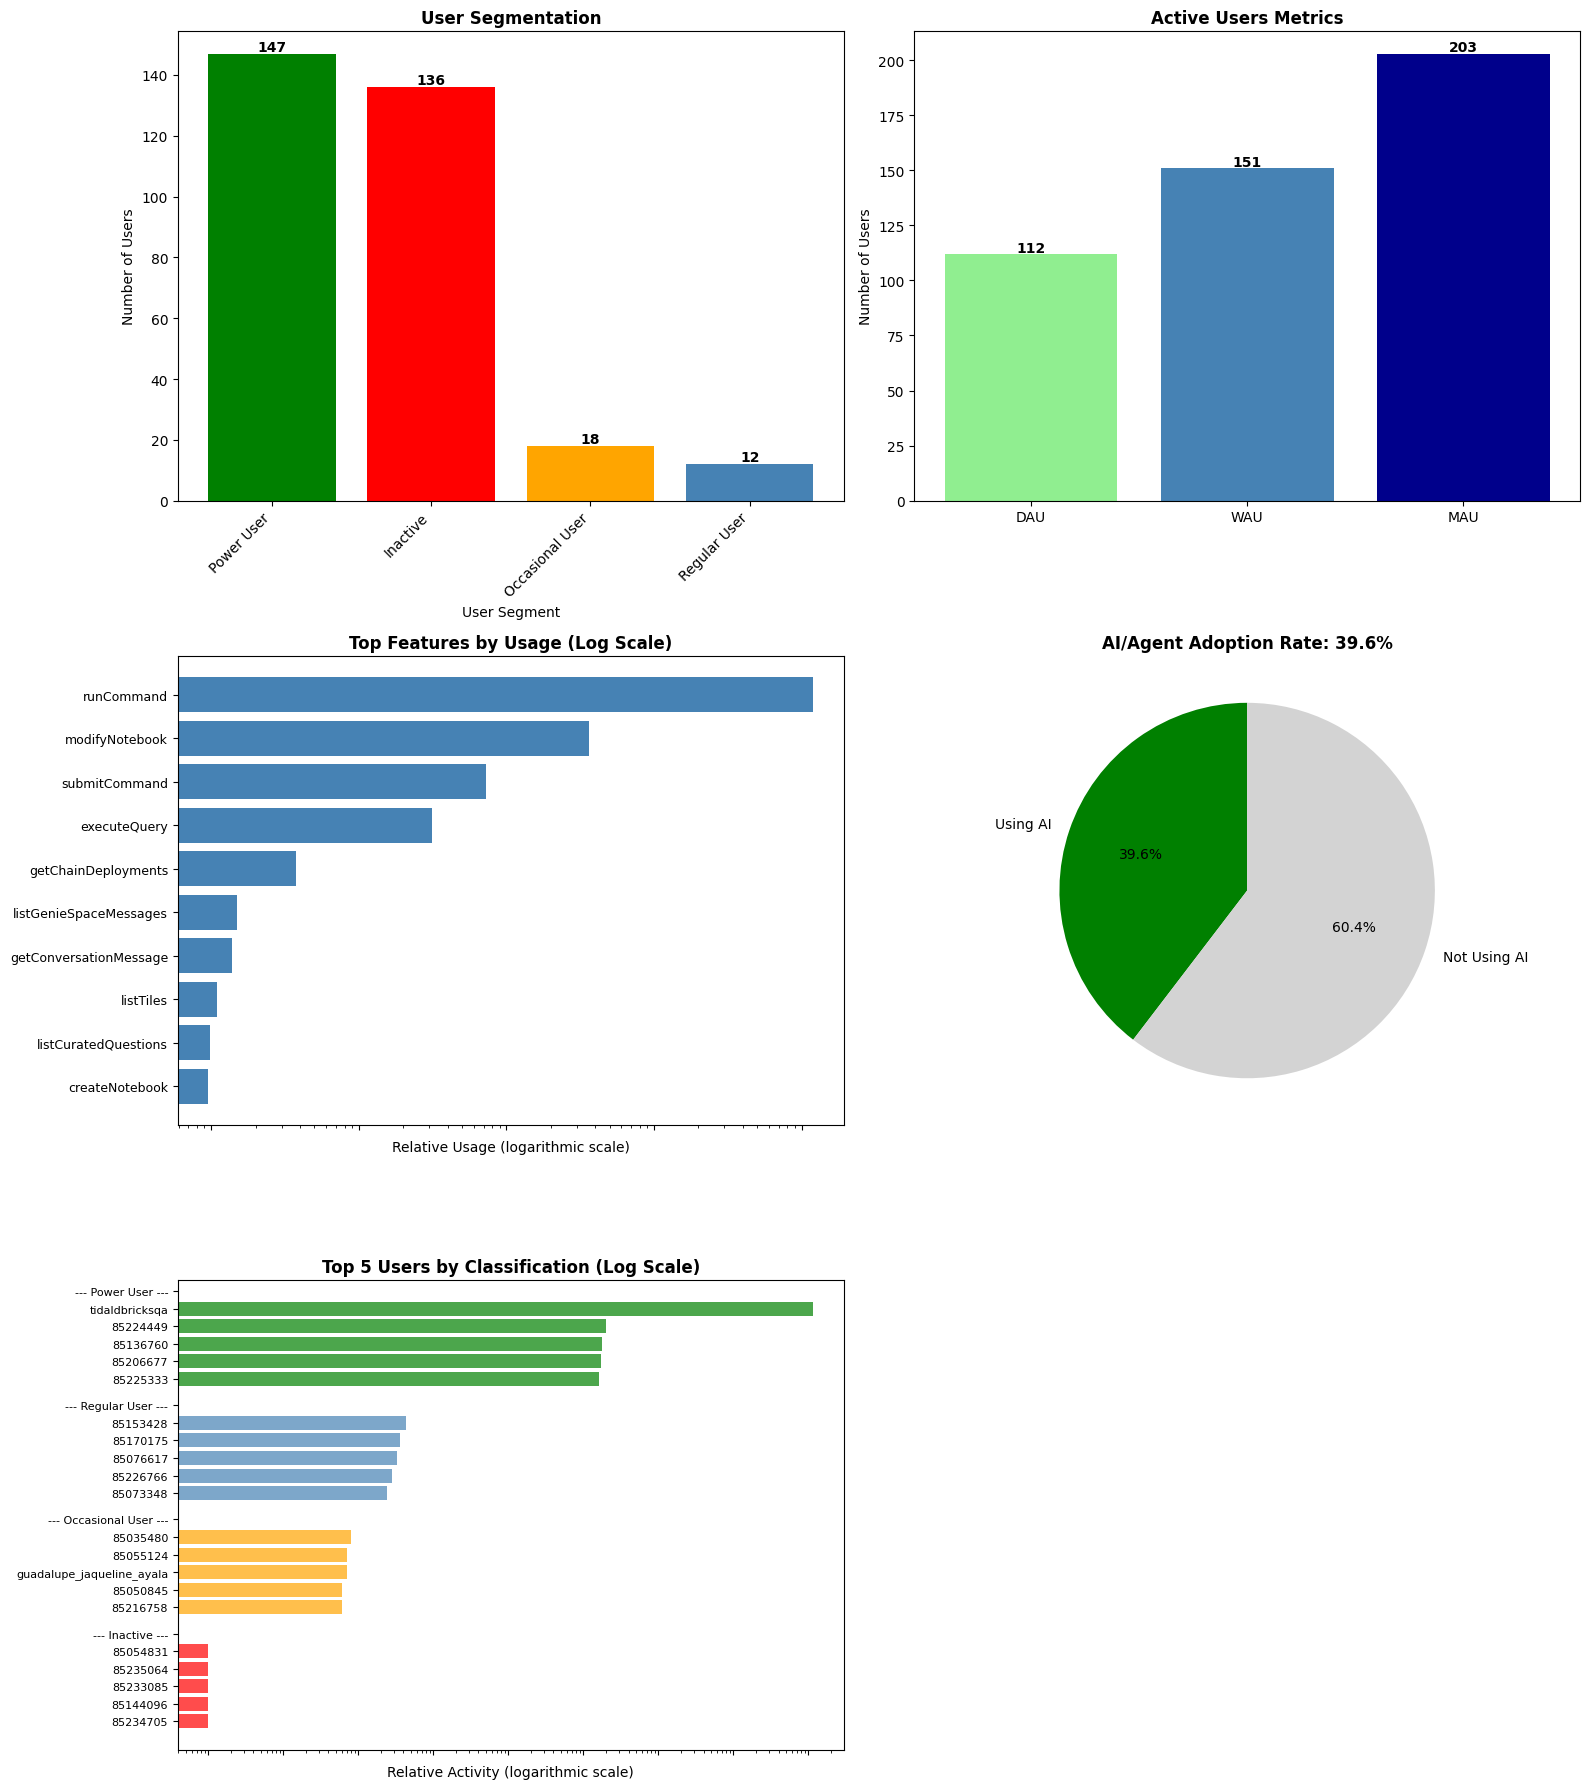

✓ Visualizations generated (5 charts)
⏱️  Visualizations completed in 158.69 seconds


In [0]:
cell_start_time = time.time()

if not is_job_mode and ENABLE_VISUALIZATIONS and user_metrics is not None:
    log("\n" + "="*60)
    log("VISUALIZATIONS")
    log("="*60)
    
    import matplotlib.pyplot as plt
    
    # Create figure with subplots (3 rows, 2 columns for 5 charts)
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # Chart 1: User Segmentation
    ax1 = axes[0, 0]
    segments = user_metrics.groupBy('user_segment').count().toPandas()
    colors = {'Power User': 'green', 'Regular User': 'steelblue', 'Occasional User': 'orange', 'Inactive': 'red'}
    bar_colors = [colors.get(seg, 'gray') for seg in segments['user_segment']]
    bars = ax1.bar(segments['user_segment'], segments['count'], color=bar_colors)
    ax1.set_title('User Segmentation', fontsize=12, fontweight='bold')
    ax1.set_xlabel('User Segment')
    ax1.set_ylabel('Number of Users')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    # Add value labels on top of bars
    for i, (bar, count) in enumerate(zip(bars, segments['count'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                str(int(count)), ha='center', fontweight='bold')
    
    # Chart 2: Active Users Trend (DAU/WAU/MAU)
    ax2 = axes[0, 1]
    active_metrics = ['DAU', 'WAU', 'MAU']
    active_counts = [dau, wau, mau]
    ax2.bar(active_metrics, active_counts, color=['lightgreen', 'steelblue', 'darkblue'])
    ax2.set_title('Active Users Metrics', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Users')
    for i, v in enumerate(active_counts):
        ax2.text(i, v + 1, str(v), ha='center', fontweight='bold')
    
    # Chart 3: Feature Usage Distribution (with logarithmic scale)
    ax3 = axes[1, 0]
    if feature_usage is not None and feature_usage.count() > 0:
        top_features = feature_usage.limit(10).toPandas()
        # Ensure no zero values for log scale
        top_features['total_uses'] = top_features['total_uses'].apply(lambda x: max(x, 0.1))
        ax3.barh(range(len(top_features)), top_features['total_uses'], color='steelblue')
        ax3.set_yticks(range(len(top_features)))
        ax3.set_yticklabels(top_features['action_name'], fontsize=9)
        ax3.set_title('Top Features by Usage (Log Scale)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Relative Usage (logarithmic scale)')
        ax3.set_xscale('log')  # Use logarithmic scale for x-axis
        ax3.set_xticklabels([])  # Hide numeric tick labels
        ax3.invert_yaxis()  # Highest at top
    
    # Chart 4: AI/Agent Adoption
    ax4 = axes[1, 1]
    if 'agent_adoption_rate' in dir():
        adoption_data = ['Using AI', 'Not Using AI']
        adoption_counts = [
            agent_usage.count() if agent_usage is not None else 0,
            total_active_users - (agent_usage.count() if agent_usage is not None else 0)
        ]
        colors_pie = ['green', 'lightgray']
        ax4.pie(adoption_counts, labels=adoption_data, autopct='%1.1f%%', colors=colors_pie, startangle=90)
        ax4.set_title(f'AI/Agent Adoption Rate: {agent_adoption_rate:.1f}%', fontsize=12, fontweight='bold')
    
    # Chart 5: Top 5 Users by Classification (with logarithmic scale)
    ax5 = axes[2, 0]
    
    # Get top 5 users from each segment
    top_users_by_segment = []
    segment_colors_map = {'Power User': 'green', 'Regular User': 'steelblue', 'Occasional User': 'orange', 'Inactive': 'red'}
    
    for segment in ['Power User', 'Regular User', 'Occasional User', 'Inactive']:
        segment_users = user_metrics.filter(F.col('user_segment') == segment) \
            .orderBy(F.desc('total_activities')) \
            .limit(5) \
            .select('user_name', 'total_activities', 'user_segment') \
            .collect()
        
        for user in segment_users:
            top_users_by_segment.append({
                'user': user.user_name.split('@')[0] if '@' in user.user_name else user.user_name,
                'activities': user.total_activities if user.total_activities > 0 else 0.1,  # Avoid log(0)
                'segment': user.user_segment,
                'color': segment_colors_map.get(segment, 'gray')
            })
    
    # Create grouped bar chart with logarithmic scale
    if top_users_by_segment:
        y_pos = 0
        y_labels = []
        y_positions = []
        
        for segment in ['Power User', 'Regular User', 'Occasional User', 'Inactive']:
            segment_data = [u for u in top_users_by_segment if u['segment'] == segment]
            
            if segment_data:
                # Add segment label
                y_labels.append(f"--- {segment} ---")
                y_positions.append(y_pos)
                y_pos += 1
                
                # Add users in this segment
                for user_data in segment_data:
                    ax5.barh(y_pos, user_data['activities'], color=user_data['color'], alpha=0.7)
                    y_labels.append(user_data['user'][:25])
                    y_positions.append(y_pos)
                    y_pos += 1
                
                y_pos += 0.5  # Add spacing between segments
        
        ax5.set_yticks(y_positions)
        ax5.set_yticklabels(y_labels, fontsize=8)
        ax5.set_title('Top 5 Users by Classification (Log Scale)', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Relative Activity (logarithmic scale)')
        ax5.set_xscale('log')  # Use logarithmic scale for x-axis
        ax5.set_xticklabels([])  # Hide numeric tick labels
        ax5.invert_yaxis()  # Highest at top
    
    # Hide the 6th subplot (bottom right)
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    log("✓ Visualizations generated (5 charts)")
else:
    if is_job_mode:
        log("ℹ️  Visualizations skipped (job mode)")
    else:
        log("ℹ️  Visualizations skipped (no data or disabled)")

log_execution_time("Visualizations", cell_start_time)

In [0]:
cell_start_time = time.time()

if ENABLE_EXCEL_EXPORT and user_metrics is not None:
    log("\n" + "="*60)
    log("EXPORTING TO EXCEL")
    log("="*60)
    
    try:
        # Create export directory
        if is_serverless:
            import tempfile
            temp_dir = tempfile.mkdtemp()
            export_path = temp_dir
        else:
            export_path = EXPORT_PATH
            os.makedirs(export_path, exist_ok=True)
        
        timestamp = datetime.now(eastern).strftime('%Y%m%d_%H%M%S')
        excel_path = f"{export_path}/adoption_report_{timestamp}.xlsx"
        
        log(f"Creating Excel workbook: {excel_path}")
        
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            # Sheet 1: User Metrics
            user_metrics.orderBy(F.desc('total_activities')).toPandas().to_excel(writer, sheet_name='User Metrics', index=False)
            
            # Sheet 2: AI/Agent Users
            if agent_usage is not None:
                agent_usage.orderBy(F.desc('agent_interactions')).toPandas().to_excel(writer, sheet_name='AI Agent Users', index=False)
            
            # Sheet 3: Feature Usage
            if feature_usage is not None:
                feature_usage.toPandas().to_excel(writer, sheet_name='Feature Usage', index=False)
            
            # Sheet 4: Inactive Users
            if 'inactive_users' in dir() and inactive_users is not None:
                inactive_users.toPandas().to_excel(writer, sheet_name='Inactive Users', index=False)
            
            # Sheet 5: Recommendations
            if recommendations_df is not None:
                recommendations_df.toPandas().to_excel(writer, sheet_name='Recommendations', index=False)
            
            # Sheet 6: Summary
            summary_data = {
                'Metric': [
                    'Total Users',
                    'Active Users',
                    'DAU',
                    'WAU',
                    'MAU',
                    'AI/Agent Adoption Rate (%)',
                    'Power Users',
                    'Inactive Users',
                    'Analysis Period (days)',
                    'Analysis Date'
                ],
                'Value': [
                    users_df.count(),
                    users_df.filter(F.col('active') == True).count(),
                    dau,
                    wau,
                    mau,
                    f"{agent_adoption_rate:.1f}" if 'agent_adoption_rate' in dir() else '0',
                    user_metrics.filter(F.col('user_segment') == 'Power User').count(),
                    inactive_count if 'inactive_count' in dir() else 0,
                    LOOKBACK_DAYS,
                    datetime.now(eastern).strftime('%Y-%m-%d %H:%M:%S')
                ]
            }
            pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)
        
        # Apply formatting
        from openpyxl import load_workbook
        from openpyxl.styles import Font, PatternFill, Alignment
        
        wb = load_workbook(excel_path)
        for sheet_name in wb.sheetnames:
            ws = wb[sheet_name]
            
            # Format header row
            for cell in ws[1]:
                cell.font = Font(bold=True, color='FFFFFF')
                cell.fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
                cell.alignment = Alignment(horizontal='center')
            
            # Auto-adjust column widths
            for column in ws.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    if cell.value:
                        max_length = max(max_length, len(str(cell.value)))
                ws.column_dimensions[column_letter].width = min(max_length + 2, 50)
        
        wb.save(excel_path)
        
        log(f"✓ Excel workbook created: {excel_path}")
        log(f"  Sheets: {len(wb.sheetnames)}")
        
    except Exception as e:
        log(f"✗ Excel export failed: {str(e)}")
else:
    log("ℹ️  Excel export skipped")

log_execution_time("Excel Export", cell_start_time)

ℹ️  Excel export skipped
⏱️  Excel Export completed in 0.00 seconds


In [0]:
cell_start_time = time.time()

if ENABLE_DELTA_EXPORT and user_metrics is not None:
    log("\n" + "="*60)
    log("EXPORTING TO DELTA TABLE")
    log("="*60)
    
    try:
        # Add audit metadata
        user_metrics_export = user_metrics.withColumn('audit_timestamp', F.current_timestamp())
        user_metrics_export = user_metrics_export.withColumn('lookback_days', F.lit(LOOKBACK_DAYS))
        user_metrics_export = user_metrics_export.withColumn('dau', F.lit(dau))
        user_metrics_export = user_metrics_export.withColumn('wau', F.lit(wau))
        user_metrics_export = user_metrics_export.withColumn('mau', F.lit(mau))
        user_metrics_export = user_metrics_export.withColumn('agent_adoption_rate', F.lit(agent_adoption_rate if 'agent_adoption_rate' in dir() else 0))
        
        # Write to Delta table (append mode)
        user_metrics_export.write \
            .format('delta') \
            .mode('append') \
            .option('mergeSchema', 'true') \
            .saveAsTable(DELTA_TABLE_NAME)
        
        log(f"✓ Delta table updated: {DELTA_TABLE_NAME}")
        log(f"  Mode: append (historical retention)")
        log(f"  Rows added: {user_metrics.count()}")
        
    except Exception as e:
        log(f"✗ Delta export failed: {str(e)}")
else:
    log("ℹ️  Delta export skipped")

log_execution_time("Delta Export", cell_start_time)

ℹ️  Delta export skipped
⏱️  Delta Export completed in 0.02 seconds


In [0]:
# ============================================================================
# EXECUTION SUMMARY
# ============================================================================

execution_time = time.time() - execution_stats['start_time']

log("\n" + "="*60)
log("EXECUTION SUMMARY")
log("="*60)

log(f"\n⏱️  Total execution time: {execution_time:.2f} seconds")

log(f"\n📊 Statistics:")
log(f"  Users analyzed: {execution_stats['users_processed']}")
log(f"  Audit records processed: {execution_stats['audit_records_processed']:,}")
log(f"  API calls: {execution_stats['api_calls']}")
log(f"  API failures: {execution_stats['api_failures']}")

if user_metrics is not None:
    log(f"\n👥 Adoption Summary:")
    log(f"  DAU: {dau}")
    log(f"  WAU: {wau}")
    log(f"  MAU: {mau}")
    if 'agent_adoption_rate' in dir():
        log(f"  AI/Agent adoption: {agent_adoption_rate:.1f}%")
    log(f"  Power users: {user_metrics.filter(F.col('user_segment') == 'Power User').count()}")
    log(f"  Inactive users: {inactive_count if 'inactive_count' in dir() else 0}")

if recommendations_df is not None:
    log(f"\n💡 Recommendations: {recommendations_df.count()}")

log("\n" + "="*60)
log("✓ COLLABORATION & ADOPTION ANALYSIS COMPLETE")
log("="*60)

# Return JSON summary for job mode
if is_job_mode:
    import json
    summary = {
        'status': 'success',
        'execution_time_seconds': execution_time,
        'users_analyzed': execution_stats['users_processed'],
        'dau': dau,
        'wau': wau,
        'mau': mau,
        'agent_adoption_rate': agent_adoption_rate if 'agent_adoption_rate' in dir() else 0,
        'inactive_users': inactive_count if 'inactive_count' in dir() else 0,
        'recommendations': recommendations_df.count() if recommendations_df is not None else 0,
        'timestamp': datetime.now(eastern).isoformat()
    }
    dbutils.notebook.exit(json.dumps(summary))


EXECUTION SUMMARY

⏱️  Total execution time: 645.89 seconds

📊 Statistics:
  Users analyzed: 313
  Audit records processed: 6,960
  API calls: 0
  API failures: 0

👥 Adoption Summary:
  DAU: 112
  WAU: 151
  MAU: 203
  AI/Agent adoption: 39.6%
  Power users: 147
  Inactive users: 136

💡 Recommendations: 2

✓ COLLABORATION & ADOPTION ANALYSIS COMPLETE
